In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

Styrene can be produced from ethylbenzene by the following reaction:
$$ \mathrm{ethylbenzene} \longleftrightarrow \mathrm{styrene} + \mathrm{H}_2 (1) $$ 
However, several irreversible side reactions also occur:
$$ \mathrm{ethylbenzene} \longrightarrow \mathrm{benzene} + \mathrm{ethylene} (2) $$
$$ \mathrm{ethylbenzene} + \mathrm{H}_2 \longrightarrow \mathrm{toluene} + \mathrm{methane} (3) $$

[J. Snyder and B. Subramaniam, Chem. Eng. Sci., 49, 5585 (1994)]. Ethylbenzene is fed at a rate of 0.00344 kmol/s to a 10.0-m3 PFR (PBR), along with inert steam at a total pressure of 2.4 atm. The steam:ethylbenzene molar ratio is initially, i.e., parts (a) to (c), 14.5:1 but can be varied.

Given the following data, find the exiting molar flow rates of styrene, benzene, and toluene along with $S_{St/BT}$ for the following inlet temperatures when the reactor is operated adiabatically:

For this problem let the following letters represent each component:

Ethylbenzene $\rightarrow$ A

Styrene $\rightarrow$ B

H$_2$ $\rightarrow$ C

Benzene $\rightarrow$ D

Ethylene $\rightarrow$ E

Toluene $\rightarrow$ F

Methane $\rightarrow$ G

Steam $\rightarrow$ S

The reactions thus becomes:
$$ A \longleftrightarrow B + C $$
$$ A \longrightarrow D + E $$
$$ A + C \longrightarrow F + G $$

# Parameters

In [2]:
Cpa = 299 # kJ/kmol.K
Cpb = 273 # kJ/kmol.K
Cpc = 30 # kJ/kmol.K
Cpd = 201 # kJ/kmol.K
Cpe = 90 # kJ/kmol.K
Cpf = 249 # kJ/kmol.K
Cpg = 68 # kJ/kmol.K
Cps = 40 # kJ/kmol.K

FAo = 0.00344 # kmol/s
V = 10 # m^3
FSo = FAo*14.5
FBo = FCo = FDo = FEo = FFo = FGo = 0
Tref = 300 # K
rho = 2137 # kg/m^3 of pellet
phi = 0.4
Po = 2.4 # atm
R = 0.082055 # atm.m^3/(K.Kmol)

DelHRX1 = 118000 # kJ/kmol A
DelHRX2 = 105200 # kJ/kmol A
DelHRX3 = -53900 # kJ/kmol A

DelCp1 = Cpb + Cpc - Cpa
DelCp2 = Cpd + Cpe - Cpa
DelCp3 = Cpf + Cpg - Cpa - Cpc

b1 = -17.34
b2 = -1.302e4
b3 = 5.051
b4 = -2.314e-10
b5 = 1.302e-6
b6 = -4.931e-3

# Kinetics

In [3]:
def Kp1(T): # atm
    return np.exp(b1 + b2/T + b3*np.log(T) + ((b4*T + b5)*T + b6)*T )

def r1Bf(T, PA, PB, PC):
    return rho*(1-phi)*np.exp(-0.08539-10925/T)*(PA - PB*PC/Kp1(T))

def r2Df(T, PA):
    return rho*(1-phi)*np.exp(13.2392 - 25000/T)*PA

def r3Ff(T, PA, PC):
    return rho*(1-phi)*np.exp(0.2961 - 11000/T)*PA*PC

# a)
$ T_o = 800 K $

In [4]:
To = 800 # K

In [5]:
def DEs(V, var):
    FA, FB, FC, FD, FE, FF, FG, FS, T, P = var
    FT = FA + FB + FC + FD + FE + FF + FG + FS

    PA = FA/FT*P
    PB = FB/FT*P
    PC = FC/FT*P

    r1B = r1C = r1Bf(T, PA, PB, PC)
    r1A = -r1B
    r2D = r2E = r2Df(T, PA)
    r2A = -r2D
    r3F = r3G = r3Ff(T, PA, PC)
    r3A = r3C = -r3F

    dFAdV = r1A + r2A + r3A
    dFBdV = r1B
    dFCdV = r1C + r3C
    dFDdV = r2D
    dFEdV = r2E
    dFFdV = r3F
    dFGdV = r3G

    denom = FA*Cpa + FB*Cpb + FC*Cpc + FD*Cpd + FE*Cpe + FF*Cpf + FG*Cpg + FS*Cps
    RX1 = r1A*(DelHRX1 + DelCp1*(T-300))
    RX2 = r2A*(DelHRX2 + DelCp2*(T-300))
    RX3 = r3A*(DelHRX3 + DelCp3*(T-300))
    num = RX1 + RX2 + RX3
    dTdV = num/denom
    dPdV = 0

    return [dFAdV, dFBdV, dFCdV, dFDdV, dFEdV, dFFdV, dFGdV, 0, dTdV, dPdV]

In [6]:
Vrange = [0, 10]
init = np.array([FAo, FBo, FCo, FDo, FEo, FFo, FGo, FSo, To, Po])
SolA = scipy.integrate.solve_ivp(DEs, Vrange, init, dense_output=True)

In [7]:
print('T_outlet = ', round(SolA.y[-2][-1], 1), 'K')
print('F_styrene =', round(SolA.y[1][-1]*1000, 2), 'mol/s')
print('S_styrene_to_tb =', round(SolA.y[1][-1]/(SolA.y[5][-1] + SolA.y[3][-1]), 2), 'mol/s')

T_outlet =  764.9 K
F_styrene = 0.89 mol/s
S_styrene_to_tb = 19.28 mol/s


In [8]:
Vols = np.arange(0, 10.01, 0.01)
plotvals = SolA.sol(Vols)
FA1, FB1, FC1, FD1, FE1, FF1, FG1, FS1, T1, P1 = plotvals

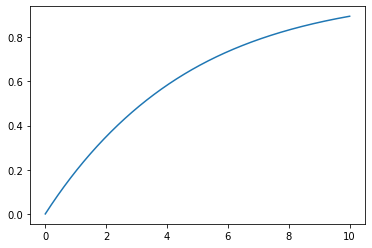

In [9]:
plt.plot(Vols, FB1*1000)

# b)
$ T_o = 930 K $

In [10]:
To = 930
Vrange = [0, 10]
init = np.array([FAo, FBo, FCo, FDo, FEo, FFo, FGo, FSo, To, Po])
SolB = scipy.integrate.solve_ivp(DEs, Vrange, init, dense_output=True)

In [11]:
print('T_outlet = ', round(SolB.y[-2][-1], 1), 'K')
print('F_styrene =', round(SolB.y[1][-1]*1000, 2), 'mol/s')
print('S_styrene_to_tb =', round(SolB.y[1][-1]/(SolB.y[5][-1] + SolB.y[3][-1]), 2), 'mol/s')

T_outlet =  850.1 K
F_styrene = 1.93 mol/s
S_styrene_to_tb = 4.63 mol/s


# c)
$ T_o = 1100 K $

In [12]:
To = 1100
Vrange = [0, 10]
init = np.array([FAo, FBo, FCo, FDo, FEo, FFo, FGo, FSo, To, Po])
SolC = scipy.integrate.solve_ivp(DEs, Vrange, init, dense_output=True)

In [13]:
print('T_outlet = ', round(SolC.y[-2][-1], 1), 'K')
print('F_styrene =', round(SolC.y[1][-1]*1000, 2), 'mol/s')
print('S_styrene_to_tb =', round(SolC.y[1][-1]/(SolC.y[5][-1] + SolC.y[3][-1]), 2), 'mol/s')

T_outlet =  983.5 K
F_styrene = 1.65 mol/s
S_styrene_to_tb = 0.95 mol/s
